# ARC 2018 Depletion Model

In [1]:
import openmc
import openmc.deplete
import openmc.data as data
import neutronics_material_maker as nmm
import math
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro
from numpy.polynomial.polynomial import Polynomial

In [2]:
percent_fertile = 0.25

## Materials ##

All material management is done using `neutronics_material_maker`. The name of each material must correspond to the name of the region of the DAGMC model to which it should be assigned.

In [3]:
# Import and read JSON file containing volume information computed by paramak
file = open('arc2018_volumes.json',)
volumes = json.load(file)
file.close()

In [4]:
nmm.AddMaterialFromFile("mat_lib.json")

def generate_materials(percent_fertile=0, Li6_enrichment=7.8):
    plasma = nmm.Material.from_library("plasma").openmc_material

    flibe = nmm.Material.from_library("flibe", enrichment=Li6_enrichment)
    uf4 = nmm.Material.from_library("uf4")

    #Creating materials for all four FLiBe regions by mixing UF4 and FLiBe materials by volume
    ib_tank = nmm.Material.from_mixture(name='inboard_tank', materials=[flibe, uf4], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material
    ob_tank = nmm.Material.from_mixture(name='outboard_tank', materials=[flibe, uf4], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material

    ib_cc = nmm.Material.from_mixture(name='inboard_cc', materials=[flibe, uf4], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material
    ob_cc = nmm.Material.from_mixture(name='outboard_cc', materials=[flibe, uf4], fracs=[1 - percent_fertile/100, percent_fertile/100], percent_type='vo').openmc_material

    ib_tank.volume = volumes['inboard_tank']
    ob_tank.volume = volumes['outboard_tank']
    ib_cc.volume = volumes['inboard_cc']
    ob_cc.volume = volumes['outboard_cc']

    ib_mult = nmm.Material.from_library("beryllium").openmc_material
    ib_mult.name = 'inboard_multiplier'

    ob_mult = nmm.Material.from_library("beryllium").openmc_material
    ob_mult.name = 'outboard_multiplier'

    ob_outer_vv = nmm.Material.from_library("Inconel-718").openmc_material
    ob_outer_vv.name = 'outboard_outer_vv'

    ib_outer_vv = nmm.Material.from_library("Inconel-718").openmc_material
    ib_outer_vv.name = 'inboard_outer_vv'

    vv = nmm.Material.from_library("tungsten").openmc_material
    vv.name = "vv"

    materials = openmc.Materials(
        [
            plasma,
            ib_tank,
            ob_tank,
            ib_cc,
            ob_cc,
            ib_mult,
            ob_mult,
            ib_outer_vv,
            ob_outer_vv,
            vv
        ]
    )

    return materials

materials = generate_materials(percent_fertile=percent_fertile)


Added materials to library from mat_lib.json
Added material ['plasma', 'flibe', 'uf4', 'tungsten', 'lead', 'beryllium']


Specify path to cross section file of desired library.

In [5]:
#Provide path to cross section data
openmc.Materials.cross_sections = "/home/jlball/xs_data/endfb80_hdf5/cross_sections.xml"

## Geometry ##

The geometry is built in a separate file which uses the Paramak code to build a DAGMC model. Here it is imported and then a bounding region is provided.

In [6]:
dag_univ = openmc.DAGMCUniverse("arc2018.h5m")

# creates an edge of universe boundary surface
vac_surf = openmc.Sphere(r=10000, surface_id=9999, boundary_type="vacuum")

# adds reflective surface for the sector model at 0 degrees
reflective_1 = openmc.Plane(
    a=math.sin(0),
    b=-math.cos(0),
    c=0.0,
    d=0.0,
    surface_id=9991,
    boundary_type="reflective",
)

# specifies the region as below the universe boundary and inside the reflective surfaces
region = -vac_surf & -reflective_1 

# creates a cell from the region and fills the cell with the dagmc geometry
containing_cell = openmc.Cell(cell_id=9999, region=region, fill=dag_univ)

geometry = openmc.Geometry(root=[containing_cell])

## Settings ##

A simple line source geometry is defined.

In [7]:
# creates a simple isotropic neutron source in the center with 14MeV neutrons
source = openmc.Source()
# the distribution of radius is just a single value at the plasma major radius
radius = openmc.stats.Discrete([330.], [1])
# the distribution of source z values is just a single value
z_values = openmc.stats.Discrete([0], [1])
# the distribution of source azimuthal angles values is a uniform distribution between 0 and 0.5 Pi
# these angles must be the same as the reflective angles
angle = openmc.stats.Uniform(a=0., b=math.radians(180))
# this makes the ring source using the three distributions and a radius
source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 0.0))
# sets the direction to isotropic
source.angle = openmc.stats.Isotropic()
# sets the energy distribution to a Muir distribution neutrons
source.energy = openmc.stats.Muir(e0=14080000.0, m_rat=5.0, kt=20000.0)

# specifies the simulation computational intensity
settings = openmc.Settings()
settings.batches = 10
settings.particles = 500
settings.inactive = 0
settings.run_mode = "fixed source"
settings.source = source

## Tallies ##

Definition of tallies used.

In [8]:
# Tritium Breeding Tally:
trit_tally = openmc.Tally(name='tbr')
#trit_tally.filters = [blanket_filter]
trit_tally.scores = ["(n,Xt)"]

# Tritium Breeding Tally:
Be_tally = openmc.Tally(name='Be')
#Be_tally.filters = [blanket_filter]
Be_tally.scores = ["(n,2n)"]

# Plutonium Breeding Tally:
plut_tally = openmc.Tally(name='pbr')
plut_tally.nuclides = ['U238']
#plut_tally.filters = [blanket_filter]
plut_tally.scores = ["absorption"]

# Uranium Breeding Tally:
u_tally = openmc.Tally(name='ubr')
u_tally.nuclides = ['Th232']
#plut_tally.filters = [blanket_filter]
u_tally.scores = ["absorption"]

#Fission tally
fis_tally = openmc.Tally(name='fis')
#fis_tally.filters = [blanket_filter]
fis_tally.scores = ['fission']

tallies = openmc.Tallies([trit_tally, plut_tally, Be_tally, fis_tally, u_tally])

## Depletion Run 

Setting up for the scan of depletion runs:

In [9]:
percents_fertile = [0.25, 0.5, 1, 2, 3.5, 5]

# this tells openmc the decay paths between isotopes including proabilities of different routes and half lives
chain_filename = 'chain_endfb71_pwr.xml'
chain = openmc.deplete.Chain.from_xml(chain_filename)

# Set depletion calculation parameters:
number_of_steps = 5
final_time = 1 * 365 * 24 #hours
fusion_power = 525 # MW

energy_per_fusion = 2.8182e-18 # MJ (comes from converting 17.59 MeV to MJ)

time_steps = [final_time*60*60 / number_of_steps] * number_of_steps
source_rates = [fusion_power / energy_per_fusion] * number_of_steps

tbrs, tbrs_std = np.empty(len(percents_fertile)), np.empty(len(percents_fertile))

In [10]:
def extract_tbr(return_arrays=False):
    num_time_steps = len(time_steps) + 1

    tbr_vals, tbr_std = np.empty(num_time_steps), np.empty(num_time_steps)
    for i in range(0, num_time_steps):
        sp = openmc.StatePoint(f'openmc_simulation_n{i}.h5')
        
        #Extract TBR values and std dev at each step in the simulation
        tbr_tally = sp.get_tally(name='tbr')
        tbr_vals[i] = tbr_tally.mean
        tbr_std[i] = tbr_tally.std_dev

    if return_arrays:
        return tbr_vals, tbr_std
    else:
        return np.mean(tbr_vals), np.mean(tbr_std)

Performing the scan:

In [11]:
for i, percent_fertile in enumerate(percents_fertile):
    # Create materials object with desired pertile percent:
    materials = generate_materials(percent_fertile=percent_fertile)

    #Create OpenMC model object using this new materials object:
    model = openmc.Model(
        materials=materials, geometry=geometry, settings=settings, tallies=tallies
    )

    # Create transport operator using the above OpenMC model
    operator = openmc.deplete.Operator(model, chain_filename, normalization_mode='source-rate')

    # Create integrator which will perform the calculation using a particular algorhithm
    integrator = openmc.deplete.PredictorIntegrator(
        operator=operator, timesteps=time_steps, source_rates=source_rates, 
    )

    print("###### BEGIN DEPLETION CALCULATION FOR", percent_fertile, "PERCENT FERTILE BLANKET ######")
    integrator.integrate()

    print("###### EXTRACT RESULTS ######")
    tbr, tbr_std = extract_tbr()
    tbrs[i] = tbr
    tbrs_std[i] = tbr_std

###### BEGIN DEPLETION CALCULATION FOR 0.25 PERCENT FERTILE BLANKET ######
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #########

 Reading Mg24 from /home/jlball/xs_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/jlball/xs_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/jlball/xs_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/jlball/xs_data/endfb80_hdf5/Al26_m1.h5
 Reading Si31 from /home/jlball/xs_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/jlball/xs_data/endfb80_hdf5/Si32.h5
 Reading S35 from /home/jlball/xs_data/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/jlball/xs_data/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/jlball/xs_data/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/jlball/xs_data/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/jlball/xs_data/endfb80_hdf5/Ar36.h5
 Reading Ar37 from /home/jlball/xs_data/endfb80_hdf5/Ar37.h5


 Reading Ar38 from /home/jlball/xs_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/jlball/xs_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/jlball/xs_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/jlball/xs_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/jlball/xs_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/jlball/xs_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/jlball/xs_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/jlball/xs_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/jlball/xs_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/jlball/xs_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/jlball/xs_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/jlball/xs_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/jlball/xs_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/jlball/xs_data/endfb80_hdf5/Ca46.h5
 Reading Ca47 from /home/jlball/xs_data/endfb80_hdf5/Ca47.h5
 Reading Ca48 from /home/jlball/xs_data/endfb80_hdf5/Ca48.h5
 Reading Sc45 from /home/jlbal

 Reading Se81 from /home/jlball/xs_data/endfb80_hdf5/Se81.h5
 Reading Se82 from /home/jlball/xs_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/jlball/xs_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/jlball/xs_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/jlball/xs_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/jlball/xs_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/jlball/xs_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/jlball/xs_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/jlball/xs_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/jlball/xs_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/jlball/xs_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/jlball/xs_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/jlball/xs_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/jlball/xs_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/jlball/xs_data/endfb80_hdf5/Rb85.h5
 Reading Rb86 from /home/jlball/xs_data/endfb80_hdf5/Rb86.h5
 Reading Rb87 from /home

 Reading Mo99 from /home/jlball/xs_data/endfb80_hdf5/Mo99.h5
 Reading Tc98 from /home/jlball/xs_data/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/jlball/xs_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/jlball/xs_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/jlball/xs_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/jlball/xs_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/jlball/xs_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/jlball/xs_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/jlball/xs_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/jlball/xs_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/jlball/xs_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/jlball/xs_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/jlball/xs_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/jlball/xs_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/jlball/xs_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/jlball/xs_data/endfb80_hdf5/Rh104.h5
 Readi

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd108 from /home/jlball/xs_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/jlball/xs_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/jlball/xs_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/jlball/xs_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/jlball/xs_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/jlball/xs_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/jlball/xs_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/jlball/xs_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/jlball/xs_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/jlball/xs_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/jlball/xs_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/jlball/xs_data/endfb80_hdf5/In115.h5
 Reading Sn112 from /home/jlball/xs_data/endfb80_hdf5/Sn112.h5
 Reading Sn113 from /home/jlball/xs_data/endfb80_hdf5/Sn113.h5
 Reading Sn114 from /home/jlball/xs_data/endfb80_hdf5/Sn114.h5
 Reading Sn115 from /home/jlball/xs_data/endfb80_

          1200K
          2500K


 Reading Sb122 from /home/jlball/xs_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/jlball/xs_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/jlball/xs_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/jlball/xs_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/jlball/xs_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/jlball/xs_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/jlball/xs_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/jlball/xs_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/jlball/xs_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/jlball/xs_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/jlball/xs_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/jlball/xs_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/jlball/xs_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/jlball/xs_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/jlball/xs_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/jlball/xs_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/jlball/xs_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/jlball/xs_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/jlball/xs_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/jlball/xs_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/jlball/xs_data/endfb80_hdf5/I127.h5
 Reading I128 from /home/jlball/xs_data/endfb80_hdf5/I128.h5
 Reading I129 from /home/jlball/xs_

 Reading I132_m1 from /home/jlball/xs_data/endfb80_hdf5/I132_m1.h5
 Reading I133 from /home/jlball/xs_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/jlball/xs_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/jlball/xs_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/jlball/xs_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/jlball/xs_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/jlball/xs_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/jlball/xs_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/jlball/xs_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/jlball/xs_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/jlball/xs_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/jlball/xs_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/jlball/xs_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/jlball/xs_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/jlball/xs_data/endfb80_hdf5/Xe133.h5


          2500K
          1200K
          2500K


 Reading Xe134 from /home/jlball/xs_data/endfb80_hdf5/Xe134.h5
 Reading Xe135 from /home/jlball/xs_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/jlball/xs_data/endfb80_hdf5/Xe136.h5
 Reading Cs133 from /home/jlball/xs_data/endfb80_hdf5/Cs133.h5
 Reading Cs134 from /home/jlball/xs_data/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/jlball/xs_data/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/jlball/xs_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/jlball/xs_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/jlball/xs_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/jlball/xs_data/endfb80_hdf5/Ba131.h5
 Reading Ba132 from /home/jlball/xs_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/jlball/xs_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/jlball/xs_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/jlball/xs_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/jlball/xs_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/jlball/xs_data/endfb80_hdf5/B

          1200K
          2500K


 Reading Gd153 from /home/jlball/xs_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/jlball/xs_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/jlball/xs_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/jlball/xs_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/jlball/xs_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/jlball/xs_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/jlball/xs_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/jlball/xs_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/jlball/xs_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/jlball/xs_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/jlball/xs_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/jlball/xs_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/jlball/xs_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/jlball/xs_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/jlball/xs_data/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/jlball/xs_data/endfb80_hdf5/D

          1200K
          2500K


 Reading Yb170 from /home/jlball/xs_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/jlball/xs_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/jlball/xs_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/jlball/xs_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/jlball/xs_data/endfb80_hdf5/Yb174.h5
 Reading Yb175 from /home/jlball/xs_data/endfb80_hdf5/Yb175.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb176 from /home/jlball/xs_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/jlball/xs_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/jlball/xs_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/jlball/xs_data/endfb80_hdf5/Hf174.h5
 Reading Hf175 from /home/jlball/xs_data/endfb80_hdf5/Hf175.h5


          1200K
          2500K


 Reading Hf176 from /home/jlball/xs_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/jlball/xs_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/jlball/xs_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/jlball/xs_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/jlball/xs_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/jlball/xs_data/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/jlball/xs_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/jlball/xs_data/endfb80_hdf5/Ta180.h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta181 from /home/jlball/xs_data/endfb80_hdf5/Ta181.h5
 Reading Ta182 from /home/jlball/xs_data/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/jlball/xs_data/endfb80_hdf5/W181.h5
 Reading W185 from /home/jlball/xs_data/endfb80_hdf5/W185.h5
 Reading Re185 from /home/jlball/xs_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/jlball/xs_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/jlball/xs_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/jlball/xs_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/jlball/xs_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/jlball/xs_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/jlball/xs_data/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/jlball/xs_data/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/jlball/xs_data/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/jlball/xs_data/endfb80_hdf5/Os190.h5
 Reading Os191 from /home/jlball/xs_data/endfb80_hdf5/Os191.h5
 Reading Os192 from /home/jlball/xs_data/endfb80_hdf5

          1200K


 Reading Cf251 from /home/jlball/xs_data/endfb80_hdf5/Cf251.h5
 Reading Cf252 from /home/jlball/xs_data/endfb80_hdf5/Cf252.h5
 Reading Cf253 from /home/jlball/xs_data/endfb80_hdf5/Cf253.h5
 Reading Cf254 from /home/jlball/xs_data/endfb80_hdf5/Cf254.h5
 Reading Es251 from /home/jlball/xs_data/endfb80_hdf5/Es251.h5
 Reading Es252 from /home/jlball/xs_data/endfb80_hdf5/Es252.h5
 Reading Es253 from /home/jlball/xs_data/endfb80_hdf5/Es253.h5
 Reading Es254 from /home/jlball/xs_data/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from /home/jlball/xs_data/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/jlball/xs_data/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/jlball/xs_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulat

 Reading Mg24 from /home/jlball/xs_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/jlball/xs_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/jlball/xs_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/jlball/xs_data/endfb80_hdf5/Al26_m1.h5
 Reading Si31 from /home/jlball/xs_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/jlball/xs_data/endfb80_hdf5/Si32.h5
 Reading S35 from /home/jlball/xs_data/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/jlball/xs_data/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/jlball/xs_data/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/jlball/xs_data/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/jlball/xs_data/endfb80_hdf5/Ar36.h5
 Reading Ar37 from /home/jlball/xs_data/endfb80_hdf5/Ar37.h5


 Reading Ar38 from /home/jlball/xs_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/jlball/xs_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/jlball/xs_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/jlball/xs_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/jlball/xs_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/jlball/xs_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/jlball/xs_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/jlball/xs_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/jlball/xs_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/jlball/xs_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/jlball/xs_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/jlball/xs_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/jlball/xs_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/jlball/xs_data/endfb80_hdf5/Ca46.h5
 Reading Ca47 from /home/jlball/xs_data/endfb80_hdf5/Ca47.h5
 Reading Ca48 from /home/jlball/xs_data/endfb80_hdf5/Ca48.h5
 Reading Sc45 from /home/jlbal

 Reading Se82 from /home/jlball/xs_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/jlball/xs_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/jlball/xs_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/jlball/xs_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/jlball/xs_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/jlball/xs_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/jlball/xs_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/jlball/xs_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/jlball/xs_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/jlball/xs_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/jlball/xs_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/jlball/xs_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/jlball/xs_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/jlball/xs_data/endfb80_hdf5/Rb85.h5
 Reading Rb86 from /home/jlball/xs_data/endfb80_hdf5/Rb86.h5
 Reading Rb87 from /home/jlball/xs_data/endfb80_hdf5/Rb87.h5
 Reading Sr84 from /home

 Reading Mo99 from /home/jlball/xs_data/endfb80_hdf5/Mo99.h5
 Reading Tc98 from /home/jlball/xs_data/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/jlball/xs_data/endfb80_hdf5/Tc99.h5


 Reading Ru96 from /home/jlball/xs_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/jlball/xs_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/jlball/xs_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/jlball/xs_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/jlball/xs_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/jlball/xs_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/jlball/xs_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/jlball/xs_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/jlball/xs_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/jlball/xs_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/jlball/xs_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/jlball/xs_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/jlball/xs_data/endfb80_hdf5/Rh104.h5
 Reading Rh105 from /home/jlball/xs_data/endfb80_hdf5/Rh105.h5
 Reading Pd102 from /home/jlball/xs_data/endfb80_hdf5/Pd102.h5
 Reading Pd103 from /home/jlball/xs_data/endfb80_hdf5/Pd103.h5


          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd106 from /home/jlball/xs_data/endfb80_hdf5/Cd106.h5
 Reading Cd107 from /home/jlball/xs_data/endfb80_hdf5/Cd107.h5
 Reading Cd108 from /home/jlball/xs_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/jlball/xs_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/jlball/xs_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/jlball/xs_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/jlball/xs_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/jlball/xs_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/jlball/xs_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/jlball/xs_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/jlball/xs_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/jlball/xs_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/jlball/xs_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/jlball/xs_data/endfb80_hdf5/In115.h5
 Reading Sn112 from /home/jlball/xs_data/endfb80_hdf5/Sn112.h5
 Reading Sn113 from /home/jlball/xs_data/endfb80_

          1200K
          2500K


 Reading Sb121 from /home/jlball/xs_data/endfb80_hdf5/Sb121.h5
 Reading Sb122 from /home/jlball/xs_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/jlball/xs_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/jlball/xs_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/jlball/xs_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/jlball/xs_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/jlball/xs_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/jlball/xs_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/jlball/xs_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/jlball/xs_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/jlball/xs_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/jlball/xs_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/jlball/xs_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/jlball/xs_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/jlball/xs_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/jlball/xs_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/jlball/xs_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/jlball/xs_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/jlball/xs_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/jlball/xs_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/jlball/xs_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/jlball/xs_data/endfb80_hdf5/I127.h5
 Reading I128 from /home/jlball/xs_data/endfb80_hdf5/I128.h5
 Reading I129 from /home/jlball/xs_

 Reading I133 from /home/jlball/xs_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/jlball/xs_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/jlball/xs_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/jlball/xs_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/jlball/xs_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/jlball/xs_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/jlball/xs_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/jlball/xs_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/jlball/xs_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/jlball/xs_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/jlball/xs_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/jlball/xs_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/jlball/xs_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/jlball/xs_data/endfb80_hdf5/Xe133.h5
 Reading Xe134 from /home/jlball/xs_data/endfb80_hdf5/Xe134.h5
 Reading Xe135 from /home/jlball/xs_data/endfb80_hdf5/Xe135.h

          2500K


 Reading Cs136 from /home/jlball/xs_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/jlball/xs_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/jlball/xs_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/jlball/xs_data/endfb80_hdf5/Ba131.h5


          1200K
          2500K


 Reading Ba132 from /home/jlball/xs_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/jlball/xs_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/jlball/xs_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/jlball/xs_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/jlball/xs_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/jlball/xs_data/endfb80_hdf5/Ba137.h5
 Reading Ba138 from /home/jlball/xs_data/endfb80_hdf5/Ba138.h5
 Reading Ba139 from /home/jlball/xs_data/endfb80_hdf5/Ba139.h5
 Reading Ba140 from /home/jlball/xs_data/endfb80_hdf5/Ba140.h5
 Reading La138 from /home/jlball/xs_data/endfb80_hdf5/La138.h5
 Reading La139 from /home/jlball/xs_data/endfb80_hdf5/La139.h5
 Reading La140 from /home/jlball/xs_data/endfb80_hdf5/La140.h5
 Reading Ce136 from /home/jlball/xs_data/endfb80_hdf5/Ce136.h5
 Reading Ce137 from /home/jlball/xs_data/endfb80_hdf5/Ce137.h5
 Reading Ce137_m1 from /home/jlball/xs_data/endfb80_hdf5/Ce137_m1.h5
 Reading Ce138 from /home/jlball/xs_data/endfb80_

          1200K
          2500K


 Reading Gd153 from /home/jlball/xs_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/jlball/xs_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/jlball/xs_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/jlball/xs_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/jlball/xs_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/jlball/xs_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/jlball/xs_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/jlball/xs_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/jlball/xs_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/jlball/xs_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/jlball/xs_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/jlball/xs_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/jlball/xs_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/jlball/xs_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/jlball/xs_data/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/jlball/xs_data/endfb80_hdf5/D

          1200K
          2500K


 Reading Yb170 from /home/jlball/xs_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/jlball/xs_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/jlball/xs_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/jlball/xs_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/jlball/xs_data/endfb80_hdf5/Yb174.h5
 Reading Yb175 from /home/jlball/xs_data/endfb80_hdf5/Yb175.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb176 from /home/jlball/xs_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/jlball/xs_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/jlball/xs_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/jlball/xs_data/endfb80_hdf5/Hf174.h5
 Reading Hf175 from /home/jlball/xs_data/endfb80_hdf5/Hf175.h5


          1200K
          2500K


 Reading Hf176 from /home/jlball/xs_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/jlball/xs_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/jlball/xs_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/jlball/xs_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/jlball/xs_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/jlball/xs_data/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/jlball/xs_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/jlball/xs_data/endfb80_hdf5/Ta180.h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta181 from /home/jlball/xs_data/endfb80_hdf5/Ta181.h5
 Reading Ta182 from /home/jlball/xs_data/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/jlball/xs_data/endfb80_hdf5/W181.h5
 Reading W185 from /home/jlball/xs_data/endfb80_hdf5/W185.h5
 Reading Re185 from /home/jlball/xs_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/jlball/xs_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/jlball/xs_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/jlball/xs_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/jlball/xs_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/jlball/xs_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/jlball/xs_data/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/jlball/xs_data/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/jlball/xs_data/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/jlball/xs_data/endfb80_hdf5/Os190.h5
 Reading Os191 from /home/jlball/xs_data/endfb80_hdf5/Os191.h5
 Reading Os192 from /home/jlball/xs_data/endfb80_hdf5

          1200K


 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.6410e+00 seconds
   Reading cross sections          = 3.1899e+00 seconds
 Total time in simulation          = 8.7008e+00 seconds
   Time in transport only          = 8.2088e+00 seconds
   Time in active batches          = 8.7008e+00 seconds
   Time accumulating tallies       = 4.7586e-01 seconds
   Time writing statepoints        = 8.0037e-03 seconds
 Total time for finalization       = 2.2020e-04 seconds
 Total time elapsed                = 1.2630e+01 seconds
 Calculation Rate (active)         = 574.

 Reading Mg24 from /home/jlball/xs_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/jlball/xs_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/jlball/xs_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/jlball/xs_data/endfb80_hdf5/Al26_m1.h5
 Reading Si31 from /home/jlball/xs_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/jlball/xs_data/endfb80_hdf5/Si32.h5
 Reading S35 from /home/jlball/xs_data/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/jlball/xs_data/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/jlball/xs_data/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/jlball/xs_data/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/jlball/xs_data/endfb80_hdf5/Ar36.h5
 Reading Ar37 from /home/jlball/xs_data/endfb80_hdf5/Ar37.h5


 Reading Ar38 from /home/jlball/xs_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/jlball/xs_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/jlball/xs_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/jlball/xs_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/jlball/xs_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/jlball/xs_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/jlball/xs_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/jlball/xs_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/jlball/xs_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/jlball/xs_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/jlball/xs_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/jlball/xs_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/jlball/xs_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/jlball/xs_data/endfb80_hdf5/Ca46.h5
 Reading Ca47 from /home/jlball/xs_data/endfb80_hdf5/Ca47.h5
 Reading Ca48 from /home/jlball/xs_data/endfb80_hdf5/Ca48.h5
 Reading Sc45 from /home/jlbal

 Reading Se81 from /home/jlball/xs_data/endfb80_hdf5/Se81.h5
 Reading Se82 from /home/jlball/xs_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/jlball/xs_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/jlball/xs_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/jlball/xs_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/jlball/xs_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/jlball/xs_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/jlball/xs_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/jlball/xs_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/jlball/xs_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/jlball/xs_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/jlball/xs_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/jlball/xs_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/jlball/xs_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/jlball/xs_data/endfb80_hdf5/Rb85.h5
 Reading Rb86 from /home/jlball/xs_data/endfb80_hdf5/Rb86.h5
 Reading Rb87 from /home

 Reading Mo99 from /home/jlball/xs_data/endfb80_hdf5/Mo99.h5
 Reading Tc98 from /home/jlball/xs_data/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/jlball/xs_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/jlball/xs_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/jlball/xs_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/jlball/xs_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/jlball/xs_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/jlball/xs_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/jlball/xs_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/jlball/xs_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/jlball/xs_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/jlball/xs_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/jlball/xs_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/jlball/xs_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/jlball/xs_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/jlball/xs_data/endfb80_hdf5/Rh104.h5
 Readi

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd106 from /home/jlball/xs_data/endfb80_hdf5/Cd106.h5
 Reading Cd107 from /home/jlball/xs_data/endfb80_hdf5/Cd107.h5
 Reading Cd108 from /home/jlball/xs_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/jlball/xs_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/jlball/xs_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/jlball/xs_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/jlball/xs_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/jlball/xs_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/jlball/xs_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/jlball/xs_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/jlball/xs_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/jlball/xs_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/jlball/xs_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/jlball/xs_data/endfb80_hdf5/In115.h5
 Reading Sn112 from /home/jlball/xs_data/endfb80_hdf5/Sn112.h5
 Reading Sn113 from /home/jlball/xs_data/endfb80_

          1200K
          2500K


 Reading Sb122 from /home/jlball/xs_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/jlball/xs_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/jlball/xs_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/jlball/xs_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/jlball/xs_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/jlball/xs_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/jlball/xs_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/jlball/xs_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/jlball/xs_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/jlball/xs_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/jlball/xs_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/jlball/xs_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/jlball/xs_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/jlball/xs_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/jlball/xs_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/jlball/xs_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/jlball/xs_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/jlball/xs_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/jlball/xs_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/jlball/xs_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/jlball/xs_data/endfb80_hdf5/I127.h5
 Reading I128 from /home/jlball/xs_data/endfb80_hdf5/I128.h5
 Reading I129 from /home/jlball/xs_

 Reading I133 from /home/jlball/xs_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/jlball/xs_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/jlball/xs_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/jlball/xs_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/jlball/xs_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/jlball/xs_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/jlball/xs_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/jlball/xs_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/jlball/xs_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/jlball/xs_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/jlball/xs_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/jlball/xs_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/jlball/xs_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/jlball/xs_data/endfb80_hdf5/Xe133.h5


          2500K
          1200K
          2500K


 Reading Xe134 from /home/jlball/xs_data/endfb80_hdf5/Xe134.h5
 Reading Xe135 from /home/jlball/xs_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/jlball/xs_data/endfb80_hdf5/Xe136.h5
 Reading Cs133 from /home/jlball/xs_data/endfb80_hdf5/Cs133.h5
 Reading Cs134 from /home/jlball/xs_data/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/jlball/xs_data/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/jlball/xs_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/jlball/xs_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/jlball/xs_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/jlball/xs_data/endfb80_hdf5/Ba131.h5
 Reading Ba132 from /home/jlball/xs_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/jlball/xs_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/jlball/xs_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/jlball/xs_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/jlball/xs_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/jlball/xs_data/endfb80_hdf5/B

          1200K
          2500K


 Reading Gd153 from /home/jlball/xs_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/jlball/xs_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/jlball/xs_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/jlball/xs_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/jlball/xs_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/jlball/xs_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/jlball/xs_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/jlball/xs_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/jlball/xs_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/jlball/xs_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/jlball/xs_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/jlball/xs_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/jlball/xs_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/jlball/xs_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/jlball/xs_data/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/jlball/xs_data/endfb80_hdf5/D

          1200K
          2500K


 Reading Yb170 from /home/jlball/xs_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/jlball/xs_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/jlball/xs_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/jlball/xs_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/jlball/xs_data/endfb80_hdf5/Yb174.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb175 from /home/jlball/xs_data/endfb80_hdf5/Yb175.h5
 Reading Yb176 from /home/jlball/xs_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/jlball/xs_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/jlball/xs_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/jlball/xs_data/endfb80_hdf5/Hf174.h5


          1200K
          2500K


 Reading Hf175 from /home/jlball/xs_data/endfb80_hdf5/Hf175.h5
 Reading Hf176 from /home/jlball/xs_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/jlball/xs_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/jlball/xs_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/jlball/xs_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/jlball/xs_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/jlball/xs_data/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/jlball/xs_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/jlball/xs_data/endfb80_hdf5/Ta180.h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta181 from /home/jlball/xs_data/endfb80_hdf5/Ta181.h5
 Reading Ta182 from /home/jlball/xs_data/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/jlball/xs_data/endfb80_hdf5/W181.h5
 Reading W185 from /home/jlball/xs_data/endfb80_hdf5/W185.h5
 Reading Re185 from /home/jlball/xs_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/jlball/xs_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/jlball/xs_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/jlball/xs_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/jlball/xs_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/jlball/xs_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/jlball/xs_data/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/jlball/xs_data/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/jlball/xs_data/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/jlball/xs_data/endfb80_hdf5/Os190.h5
 Reading Os191 from /home/jlball/xs_data/endfb80_hdf5/Os191.h5
 Reading Os192 from /home/jlball/xs_data/endfb80_hdf5

          1200K


 Reading Es251 from /home/jlball/xs_data/endfb80_hdf5/Es251.h5
 Reading Es252 from /home/jlball/xs_data/endfb80_hdf5/Es252.h5
 Reading Es253 from /home/jlball/xs_data/endfb80_hdf5/Es253.h5
 Reading Es254 from /home/jlball/xs_data/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from /home/jlball/xs_data/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/jlball/xs_data/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/jlball/xs_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.6733e+00 seconds
   Reading cross sections          = 3.256

 Reading Mg24 from /home/jlball/xs_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/jlball/xs_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/jlball/xs_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/jlball/xs_data/endfb80_hdf5/Al26_m1.h5
 Reading Si31 from /home/jlball/xs_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/jlball/xs_data/endfb80_hdf5/Si32.h5
 Reading S35 from /home/jlball/xs_data/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/jlball/xs_data/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/jlball/xs_data/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/jlball/xs_data/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/jlball/xs_data/endfb80_hdf5/Ar36.h5
 Reading Ar37 from /home/jlball/xs_data/endfb80_hdf5/Ar37.h5


 Reading Ar38 from /home/jlball/xs_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/jlball/xs_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/jlball/xs_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/jlball/xs_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/jlball/xs_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/jlball/xs_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/jlball/xs_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/jlball/xs_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/jlball/xs_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/jlball/xs_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/jlball/xs_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/jlball/xs_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/jlball/xs_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/jlball/xs_data/endfb80_hdf5/Ca46.h5
 Reading Ca47 from /home/jlball/xs_data/endfb80_hdf5/Ca47.h5
 Reading Ca48 from /home/jlball/xs_data/endfb80_hdf5/Ca48.h5
 Reading Sc45 from /home/jlbal

 Reading Se82 from /home/jlball/xs_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/jlball/xs_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/jlball/xs_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/jlball/xs_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/jlball/xs_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/jlball/xs_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/jlball/xs_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/jlball/xs_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/jlball/xs_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/jlball/xs_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/jlball/xs_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/jlball/xs_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/jlball/xs_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/jlball/xs_data/endfb80_hdf5/Rb85.h5
 Reading Rb86 from /home/jlball/xs_data/endfb80_hdf5/Rb86.h5
 Reading Rb87 from /home/jlball/xs_data/endfb80_hdf5/Rb87.h5
 Reading Sr84 from /home

 Reading Nb94 from /home/jlball/xs_data/endfb80_hdf5/Nb94.h5
 Reading Nb95 from /home/jlball/xs_data/endfb80_hdf5/Nb95.h5
 Reading Mo93 from /home/jlball/xs_data/endfb80_hdf5/Mo93.h5
 Reading Mo99 from /home/jlball/xs_data/endfb80_hdf5/Mo99.h5


 Reading Tc98 from /home/jlball/xs_data/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/jlball/xs_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/jlball/xs_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/jlball/xs_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/jlball/xs_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/jlball/xs_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/jlball/xs_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/jlball/xs_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/jlball/xs_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/jlball/xs_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/jlball/xs_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/jlball/xs_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/jlball/xs_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/jlball/xs_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/jlball/xs_data/endfb80_hdf5/Rh104.h5
 Reading Rh105 from /home/jlball/xs_data/endfb80_hdf5/Rh105.h5
 Rea

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd106 from /home/jlball/xs_data/endfb80_hdf5/Cd106.h5
 Reading Cd107 from /home/jlball/xs_data/endfb80_hdf5/Cd107.h5
 Reading Cd108 from /home/jlball/xs_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/jlball/xs_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/jlball/xs_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/jlball/xs_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/jlball/xs_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/jlball/xs_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/jlball/xs_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/jlball/xs_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/jlball/xs_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/jlball/xs_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/jlball/xs_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/jlball/xs_data/endfb80_hdf5/In115.h5
 Reading Sn112 from /home/jlball/xs_data/endfb80_hdf5/Sn112.h5
 Reading Sn113 from /home/jlball/xs_data/endfb80_

          1200K
          2500K


 Reading Sb122 from /home/jlball/xs_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/jlball/xs_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/jlball/xs_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/jlball/xs_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/jlball/xs_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/jlball/xs_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/jlball/xs_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/jlball/xs_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/jlball/xs_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/jlball/xs_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/jlball/xs_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/jlball/xs_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/jlball/xs_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/jlball/xs_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/jlball/xs_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/jlball/xs_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/jlball/xs_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/jlball/xs_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/jlball/xs_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/jlball/xs_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/jlball/xs_data/endfb80_hdf5/I127.h5
 Reading I128 from /home/jlball/xs_data/endfb80_hdf5/I128.h5
 Reading I129 from /home/jlball/xs_

 Reading I132_m1 from /home/jlball/xs_data/endfb80_hdf5/I132_m1.h5
 Reading I133 from /home/jlball/xs_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/jlball/xs_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/jlball/xs_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/jlball/xs_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/jlball/xs_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/jlball/xs_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/jlball/xs_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/jlball/xs_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/jlball/xs_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/jlball/xs_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/jlball/xs_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/jlball/xs_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/jlball/xs_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/jlball/xs_data/endfb80_hdf5/Xe133.h5


          2500K
          1200K
          2500K


 Reading Xe134 from /home/jlball/xs_data/endfb80_hdf5/Xe134.h5
 Reading Xe135 from /home/jlball/xs_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/jlball/xs_data/endfb80_hdf5/Xe136.h5
 Reading Cs133 from /home/jlball/xs_data/endfb80_hdf5/Cs133.h5
 Reading Cs134 from /home/jlball/xs_data/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/jlball/xs_data/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/jlball/xs_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/jlball/xs_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/jlball/xs_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/jlball/xs_data/endfb80_hdf5/Ba131.h5
 Reading Ba132 from /home/jlball/xs_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/jlball/xs_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/jlball/xs_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/jlball/xs_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/jlball/xs_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/jlball/xs_data/endfb80_hdf5/B

          1200K
          2500K


 Reading Gd153 from /home/jlball/xs_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/jlball/xs_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/jlball/xs_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/jlball/xs_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/jlball/xs_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/jlball/xs_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/jlball/xs_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/jlball/xs_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/jlball/xs_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/jlball/xs_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/jlball/xs_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/jlball/xs_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/jlball/xs_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/jlball/xs_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/jlball/xs_data/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/jlball/xs_data/endfb80_hdf5/D

          1200K
          2500K


 Reading Yb170 from /home/jlball/xs_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/jlball/xs_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/jlball/xs_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/jlball/xs_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/jlball/xs_data/endfb80_hdf5/Yb174.h5
 Reading Yb175 from /home/jlball/xs_data/endfb80_hdf5/Yb175.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb176 from /home/jlball/xs_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/jlball/xs_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/jlball/xs_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/jlball/xs_data/endfb80_hdf5/Hf174.h5
 Reading Hf175 from /home/jlball/xs_data/endfb80_hdf5/Hf175.h5


          1200K
          2500K


 Reading Hf176 from /home/jlball/xs_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/jlball/xs_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/jlball/xs_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/jlball/xs_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/jlball/xs_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/jlball/xs_data/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/jlball/xs_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/jlball/xs_data/endfb80_hdf5/Ta180.h5
 Reading Ta181 from /home/jlball/xs_data/endfb80_hdf5/Ta181.h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta182 from /home/jlball/xs_data/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/jlball/xs_data/endfb80_hdf5/W181.h5
 Reading W185 from /home/jlball/xs_data/endfb80_hdf5/W185.h5
 Reading Re185 from /home/jlball/xs_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/jlball/xs_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/jlball/xs_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/jlball/xs_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/jlball/xs_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/jlball/xs_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/jlball/xs_data/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/jlball/xs_data/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/jlball/xs_data/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/jlball/xs_data/endfb80_hdf5/Os190.h5
 Reading Os191 from /home/jlball/xs_data/endfb80_hdf5/Os191.h5
 Reading Os192 from /home/jlball/xs_data/endfb80_hdf5/Os192.h5
 Reading Ir191 from /home/jlball/xs_data/endfb80_hdf5

          1200K


 Reading Es253 from /home/jlball/xs_data/endfb80_hdf5/Es253.h5
 Reading Es254 from /home/jlball/xs_data/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from /home/jlball/xs_data/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/jlball/xs_data/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/jlball/xs_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.6415e+00 seconds
   Reading cross sections          = 3.1818e+00 seconds
 Total time in simulation          = 8.7782e+00 seconds
   Time in transport only          = 8.3012e+00 seconds


 Reading Mg25 from /home/jlball/xs_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/jlball/xs_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/jlball/xs_data/endfb80_hdf5/Al26_m1.h5
 Reading Si31 from /home/jlball/xs_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/jlball/xs_data/endfb80_hdf5/Si32.h5
 Reading S35 from /home/jlball/xs_data/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/jlball/xs_data/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/jlball/xs_data/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/jlball/xs_data/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/jlball/xs_data/endfb80_hdf5/Ar36.h5
 Reading Ar37 from /home/jlball/xs_data/endfb80_hdf5/Ar37.h5


 Reading Ar38 from /home/jlball/xs_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/jlball/xs_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/jlball/xs_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/jlball/xs_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/jlball/xs_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/jlball/xs_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/jlball/xs_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/jlball/xs_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/jlball/xs_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/jlball/xs_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/jlball/xs_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/jlball/xs_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/jlball/xs_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/jlball/xs_data/endfb80_hdf5/Ca46.h5
 Reading Ca47 from /home/jlball/xs_data/endfb80_hdf5/Ca47.h5
 Reading Ca48 from /home/jlball/xs_data/endfb80_hdf5/Ca48.h5
 Reading Sc45 from /home/jlbal

 Reading Se82 from /home/jlball/xs_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/jlball/xs_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/jlball/xs_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/jlball/xs_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/jlball/xs_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/jlball/xs_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/jlball/xs_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/jlball/xs_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/jlball/xs_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/jlball/xs_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/jlball/xs_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/jlball/xs_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/jlball/xs_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/jlball/xs_data/endfb80_hdf5/Rb85.h5
 Reading Rb86 from /home/jlball/xs_data/endfb80_hdf5/Rb86.h5
 Reading Rb87 from /home/jlball/xs_data/endfb80_hdf5/Rb87.h5
 Reading Sr84 from /home

 Reading Mo99 from /home/jlball/xs_data/endfb80_hdf5/Mo99.h5
 Reading Tc98 from /home/jlball/xs_data/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/jlball/xs_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/jlball/xs_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/jlball/xs_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/jlball/xs_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/jlball/xs_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/jlball/xs_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/jlball/xs_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/jlball/xs_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/jlball/xs_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/jlball/xs_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/jlball/xs_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/jlball/xs_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/jlball/xs_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/jlball/xs_data/endfb80_hdf5/Rh104.h5
 Readi

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd106 from /home/jlball/xs_data/endfb80_hdf5/Cd106.h5
 Reading Cd107 from /home/jlball/xs_data/endfb80_hdf5/Cd107.h5
 Reading Cd108 from /home/jlball/xs_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/jlball/xs_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/jlball/xs_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/jlball/xs_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/jlball/xs_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/jlball/xs_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/jlball/xs_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/jlball/xs_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/jlball/xs_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/jlball/xs_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/jlball/xs_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/jlball/xs_data/endfb80_hdf5/In115.h5
 Reading Sn112 from /home/jlball/xs_data/endfb80_hdf5/Sn112.h5
 Reading Sn113 from /home/jlball/xs_data/endfb80_

          1200K
          2500K


 Reading Sb122 from /home/jlball/xs_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/jlball/xs_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/jlball/xs_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/jlball/xs_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/jlball/xs_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/jlball/xs_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/jlball/xs_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/jlball/xs_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/jlball/xs_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/jlball/xs_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/jlball/xs_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/jlball/xs_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/jlball/xs_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/jlball/xs_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/jlball/xs_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/jlball/xs_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/jlball/xs_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/jlball/xs_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/jlball/xs_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/jlball/xs_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/jlball/xs_data/endfb80_hdf5/I127.h5
 Reading I128 from /home/jlball/xs_data/endfb80_hdf5/I128.h5
 Reading I129 from /home/jlball/xs_

 Reading I133 from /home/jlball/xs_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/jlball/xs_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/jlball/xs_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/jlball/xs_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/jlball/xs_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/jlball/xs_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/jlball/xs_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/jlball/xs_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/jlball/xs_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/jlball/xs_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/jlball/xs_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/jlball/xs_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/jlball/xs_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/jlball/xs_data/endfb80_hdf5/Xe133.h5


          2500K
          1200K
          2500K


 Reading Xe134 from /home/jlball/xs_data/endfb80_hdf5/Xe134.h5
 Reading Xe135 from /home/jlball/xs_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/jlball/xs_data/endfb80_hdf5/Xe136.h5
 Reading Cs133 from /home/jlball/xs_data/endfb80_hdf5/Cs133.h5
 Reading Cs134 from /home/jlball/xs_data/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/jlball/xs_data/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/jlball/xs_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/jlball/xs_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/jlball/xs_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/jlball/xs_data/endfb80_hdf5/Ba131.h5
 Reading Ba132 from /home/jlball/xs_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/jlball/xs_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/jlball/xs_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/jlball/xs_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/jlball/xs_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/jlball/xs_data/endfb80_hdf5/B

          1200K
          2500K


 Reading Gd153 from /home/jlball/xs_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/jlball/xs_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/jlball/xs_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/jlball/xs_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/jlball/xs_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/jlball/xs_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/jlball/xs_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/jlball/xs_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/jlball/xs_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/jlball/xs_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/jlball/xs_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/jlball/xs_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/jlball/xs_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/jlball/xs_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/jlball/xs_data/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/jlball/xs_data/endfb80_hdf5/D

          1200K
          2500K


 Reading Yb170 from /home/jlball/xs_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/jlball/xs_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/jlball/xs_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/jlball/xs_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/jlball/xs_data/endfb80_hdf5/Yb174.h5
 Reading Yb175 from /home/jlball/xs_data/endfb80_hdf5/Yb175.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb176 from /home/jlball/xs_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/jlball/xs_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/jlball/xs_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/jlball/xs_data/endfb80_hdf5/Hf174.h5
 Reading Hf175 from /home/jlball/xs_data/endfb80_hdf5/Hf175.h5


          1200K
          2500K


 Reading Hf176 from /home/jlball/xs_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/jlball/xs_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/jlball/xs_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/jlball/xs_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/jlball/xs_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/jlball/xs_data/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/jlball/xs_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/jlball/xs_data/endfb80_hdf5/Ta180.h5
 Reading Ta181 from /home/jlball/xs_data/endfb80_hdf5/Ta181.h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta182 from /home/jlball/xs_data/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/jlball/xs_data/endfb80_hdf5/W181.h5
 Reading W185 from /home/jlball/xs_data/endfb80_hdf5/W185.h5
 Reading Re185 from /home/jlball/xs_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/jlball/xs_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/jlball/xs_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/jlball/xs_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/jlball/xs_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/jlball/xs_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/jlball/xs_data/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/jlball/xs_data/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/jlball/xs_data/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/jlball/xs_data/endfb80_hdf5/Os190.h5
 Reading Os191 from /home/jlball/xs_data/endfb80_hdf5/Os191.h5
 Reading Os192 from /home/jlball/xs_data/endfb80_hdf5/Os192.h5
 Reading Ir191 from /home/jlball/xs_data/endfb80_hdf5

          1200K


 Reading Fm255 from /home/jlball/xs_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.5484e+00 seconds
   Reading cross sections          = 3.0950e+00 seconds
 Total time in simulation          = 9.0214e+00 seconds
   Time in transport only          = 8.5019e+00 seconds
   Time in active batches          = 9.0214e+00 seconds
   Time accumulating tallies       = 5.0494e-01 seconds
   Time writing statepoints        = 3.4829e-03 seconds
 Total time for finalization       = 1.0901e-04 seconds
 Total time elapsed               

 Reading Mg24 from /home/jlball/xs_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/jlball/xs_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/jlball/xs_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/jlball/xs_data/endfb80_hdf5/Al26_m1.h5
 Reading Si31 from /home/jlball/xs_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/jlball/xs_data/endfb80_hdf5/Si32.h5
 Reading S35 from /home/jlball/xs_data/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/jlball/xs_data/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/jlball/xs_data/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/jlball/xs_data/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/jlball/xs_data/endfb80_hdf5/Ar36.h5
 Reading Ar37 from /home/jlball/xs_data/endfb80_hdf5/Ar37.h5


 Reading Ar38 from /home/jlball/xs_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/jlball/xs_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/jlball/xs_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/jlball/xs_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/jlball/xs_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/jlball/xs_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/jlball/xs_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/jlball/xs_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/jlball/xs_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/jlball/xs_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/jlball/xs_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/jlball/xs_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/jlball/xs_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/jlball/xs_data/endfb80_hdf5/Ca46.h5
 Reading Ca47 from /home/jlball/xs_data/endfb80_hdf5/Ca47.h5
 Reading Ca48 from /home/jlball/xs_data/endfb80_hdf5/Ca48.h5
 Reading Sc45 from /home/jlbal

 Reading Se82 from /home/jlball/xs_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/jlball/xs_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/jlball/xs_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/jlball/xs_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/jlball/xs_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/jlball/xs_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/jlball/xs_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/jlball/xs_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/jlball/xs_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/jlball/xs_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/jlball/xs_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/jlball/xs_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/jlball/xs_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/jlball/xs_data/endfb80_hdf5/Rb85.h5
 Reading Rb86 from /home/jlball/xs_data/endfb80_hdf5/Rb86.h5
 Reading Rb87 from /home/jlball/xs_data/endfb80_hdf5/Rb87.h5
 Reading Sr84 from /home

 Reading Tc98 from /home/jlball/xs_data/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/jlball/xs_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/jlball/xs_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/jlball/xs_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/jlball/xs_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/jlball/xs_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/jlball/xs_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/jlball/xs_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/jlball/xs_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/jlball/xs_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/jlball/xs_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/jlball/xs_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/jlball/xs_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/jlball/xs_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/jlball/xs_data/endfb80_hdf5/Rh104.h5
 Reading Rh105 from /home/jlball/xs_data/endfb80_hdf5/Rh105.h5
 Rea

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd108 from /home/jlball/xs_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/jlball/xs_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/jlball/xs_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/jlball/xs_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/jlball/xs_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/jlball/xs_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/jlball/xs_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/jlball/xs_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/jlball/xs_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/jlball/xs_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/jlball/xs_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/jlball/xs_data/endfb80_hdf5/In115.h5
 Reading Sn112 from /home/jlball/xs_data/endfb80_hdf5/Sn112.h5
 Reading Sn113 from /home/jlball/xs_data/endfb80_hdf5/Sn113.h5
 Reading Sn114 from /home/jlball/xs_data/endfb80_hdf5/Sn114.h5
 Reading Sn115 from /home/jlball/xs_data/endfb80_

          1200K
          2500K


 Reading Sn126 from /home/jlball/xs_data/endfb80_hdf5/Sn126.h5
 Reading Sb121 from /home/jlball/xs_data/endfb80_hdf5/Sb121.h5
 Reading Sb122 from /home/jlball/xs_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/jlball/xs_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/jlball/xs_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/jlball/xs_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/jlball/xs_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/jlball/xs_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/jlball/xs_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/jlball/xs_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/jlball/xs_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/jlball/xs_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/jlball/xs_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/jlball/xs_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/jlball/xs_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/jlball/xs_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/jlball/xs_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/jlball/xs_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/jlball/xs_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/jlball/xs_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/jlball/xs_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/jlball/xs_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/jlball/xs_data/endfb80_hdf5/I127.h5
 Reading I128 from /home/jlball/xs_data/endfb80_hdf5/I128.h5
 Reading I129 from /home/jlball/xs_

 Reading I132_m1 from /home/jlball/xs_data/endfb80_hdf5/I132_m1.h5
 Reading I133 from /home/jlball/xs_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/jlball/xs_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/jlball/xs_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/jlball/xs_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/jlball/xs_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/jlball/xs_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/jlball/xs_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/jlball/xs_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/jlball/xs_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/jlball/xs_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/jlball/xs_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/jlball/xs_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/jlball/xs_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/jlball/xs_data/endfb80_hdf5/Xe133.h5
 Reading Xe134 from /home/jlball/xs_data/endfb80_hdf5/Xe1

          2500K
          1200K
          2500K


 Reading Cs136 from /home/jlball/xs_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/jlball/xs_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/jlball/xs_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/jlball/xs_data/endfb80_hdf5/Ba131.h5
 Reading Ba132 from /home/jlball/xs_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/jlball/xs_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/jlball/xs_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/jlball/xs_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/jlball/xs_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/jlball/xs_data/endfb80_hdf5/Ba137.h5
 Reading Ba138 from /home/jlball/xs_data/endfb80_hdf5/Ba138.h5
 Reading Ba139 from /home/jlball/xs_data/endfb80_hdf5/Ba139.h5
 Reading Ba140 from /home/jlball/xs_data/endfb80_hdf5/Ba140.h5
 Reading La138 from /home/jlball/xs_data/endfb80_hdf5/La138.h5
 Reading La139 from /home/jlball/xs_data/endfb80_hdf5/La139.h5
 Reading La140 from /home/jlball/xs_data/endfb80_hdf5/L

          1200K
          2500K


 Reading Gd153 from /home/jlball/xs_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/jlball/xs_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/jlball/xs_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/jlball/xs_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/jlball/xs_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/jlball/xs_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/jlball/xs_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/jlball/xs_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/jlball/xs_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/jlball/xs_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/jlball/xs_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/jlball/xs_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/jlball/xs_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/jlball/xs_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/jlball/xs_data/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/jlball/xs_data/endfb80_hdf5/D

          1200K
          2500K


 Reading Yb170 from /home/jlball/xs_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/jlball/xs_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/jlball/xs_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/jlball/xs_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/jlball/xs_data/endfb80_hdf5/Yb174.h5
 Reading Yb175 from /home/jlball/xs_data/endfb80_hdf5/Yb175.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb176 from /home/jlball/xs_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/jlball/xs_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/jlball/xs_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/jlball/xs_data/endfb80_hdf5/Hf174.h5


          1200K
          2500K


 Reading Hf175 from /home/jlball/xs_data/endfb80_hdf5/Hf175.h5
 Reading Hf176 from /home/jlball/xs_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/jlball/xs_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/jlball/xs_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/jlball/xs_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/jlball/xs_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/jlball/xs_data/endfb80_hdf5/Hf181.h5


          1200K
          2500K
          1200K
          2500K


 Reading Hf182 from /home/jlball/xs_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/jlball/xs_data/endfb80_hdf5/Ta180.h5
 Reading Ta181 from /home/jlball/xs_data/endfb80_hdf5/Ta181.h5
 Reading Ta182 from /home/jlball/xs_data/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/jlball/xs_data/endfb80_hdf5/W181.h5
 Reading W185 from /home/jlball/xs_data/endfb80_hdf5/W185.h5
 Reading Re185 from /home/jlball/xs_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/jlball/xs_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/jlball/xs_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/jlball/xs_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/jlball/xs_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/jlball/xs_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/jlball/xs_data/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/jlball/xs_data/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/jlball/xs_data/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/jlball/xs_data/endfb80_hdf5

          1200K


 Reading Es254 from /home/jlball/xs_data/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from /home/jlball/xs_data/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/jlball/xs_data/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/jlball/xs_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 4.0736e+00 seconds
   Reading cross sections          = 3.6226e+00 seconds
 Total time in simulation          = 8.8143e+00 seconds
   Time in transport only          = 8.3922e+00 seconds
   Time in active batches          = 8.8143e+00 seconds
   Time

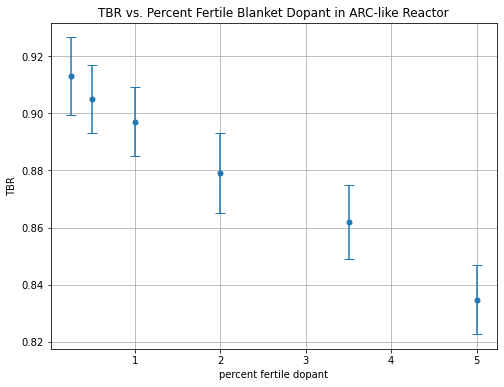

In [13]:
results = openmc.deplete.ResultsList.from_hdf5("depletion_results.h5")
times, _ = results.get_atoms("10", 'Pu239') 



fig, ax = plt.subplots()
ax.errorbar(percents_fertile, tbrs, yerr=tbrs_std, fmt='.', ms=10, capsize=5)


ax.set(title="TBR vs. Percent Fertile Blanket Dopant in ARC-like Reactor", xlabel="percent fertile dopant", ylabel='TBR')
ax.grid()

plt.gcf().set_size_inches(8, 6)
plt.show()